In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle
from pathlib import Path
from importlib import reload
from IPython.display import clear_output

from IEFC_modules import iefc_functions

from roman_cgi_iefc import cgi, iefc_sim
import misc

data_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')

wavelength_c = 575e-9*u.m

wavelength_ref = 0.5e-6*u.m
pixelscale_lamD_ref = 1/2
pixelscale_ref = 13e-6*u.m/u.pix
pixelscale_lamD = pixelscale_lamD_ref * (wavelength_ref/wavelength_c)

wavelength = 575e-9*u.m
npsf = 64
psf_pixelscale = 13e-6*u.m/u.pix
psf_pixelscale_lamD = pixelscale_lamD * (psf_pixelscale/pixelscale_ref)
print(psf_pixelscale_lamD)

flatmaps_dir = Path.home()/'src/pyfalco/roman/flatmaps'

dm1_flatmap = fits.getdata(flatmaps_dir/'dm1_m_flat_hlc_band1.fits')
dm2_flatmap = fits.getdata(flatmaps_dir/'dm2_m_flat_hlc_band1.fits')
dm1_design = fits.getdata(flatmaps_dir/'dm1_m_design_hlc_band1.fits')
dm2_design = fits.getdata(flatmaps_dir/'dm2_m_design_hlc_band1.fits')


0.43478260869565216


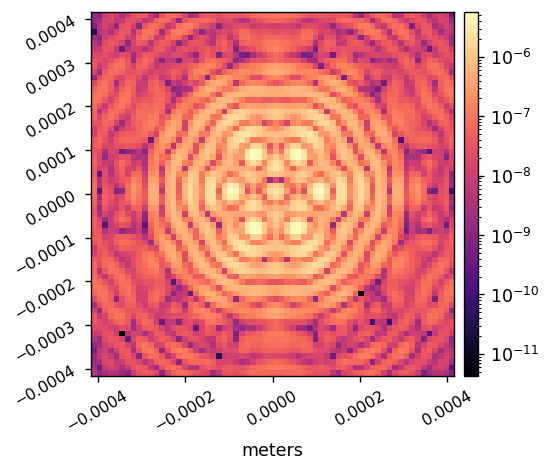

In [2]:
reload(cgi)

hlci = cgi.CGI_PROPER(use_opds=False, use_fieldstop=False, quiet=True)
# hlci.set_dm1(dm1_flatmap)
# hlci.set_dm2(dm2_flatmap)

psf = hlci.calc_psf()

misc.myimshow(psf, lognorm=True, pxscl=hlci.psf_pixelscale)

# Create dark hole ROI to calibrate and control

(4096,) (4096,) (4096,) (4096,)


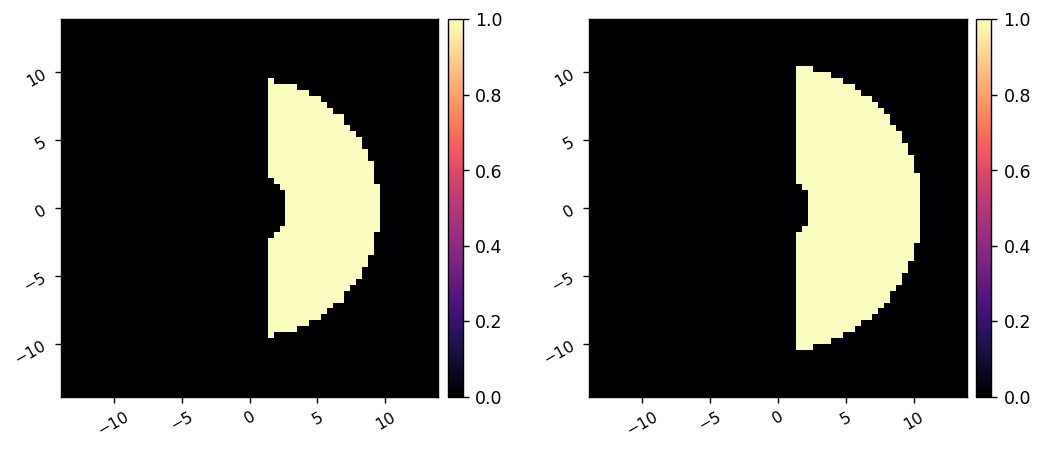

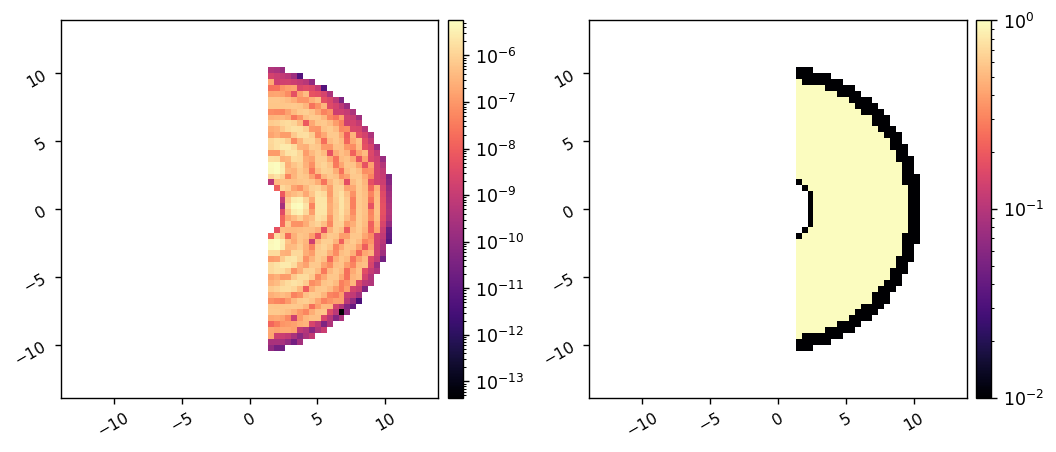

In [3]:
reload(iefc_sim)
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 1.5
iwa = 2.8
owa = 9.7

# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : '+x'
}
dh_mask = iefc_sim.create_dshaped_focal_plane_mask(xf, yf, dh_params).ravel()

#Create the mask that is used to select which region to make dark.
control_params = {
    'inner_radius' : iwa-0.5,
    'outer_radius' : owa+1,
    'edge_position' : edge,
    'direction' : '+x'
}
control_mask = iefc_sim.create_dshaped_focal_plane_mask(xf, yf, control_params).ravel()

relative_weight = 0.99
weights = dh_mask * relative_weight + (1 - relative_weight) * control_mask

print(dh_mask.shape, control_mask.shape, control_mask.shape, weights.shape)
misc.myimshow2(dh_mask.reshape(npsf,npsf), control_mask.reshape(npsf,npsf), 
               pxscl1=psf_pixelscale_lamD, pxscl2=psf_pixelscale_lamD)
misc.myimshow2(psf*weights.reshape(npsf,npsf), weights.reshape(npsf,npsf), lognorm1=True, lognorm2=True,
               pxscl1=psf_pixelscale_lamD, pxscl2=psf_pixelscale_lamD)

# Create probe and fourier modes

Creating Fourier modes:  (64, 64)
(326, 2304) (2, 2304)


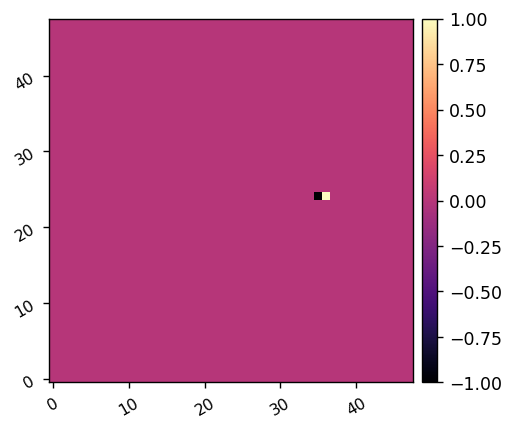

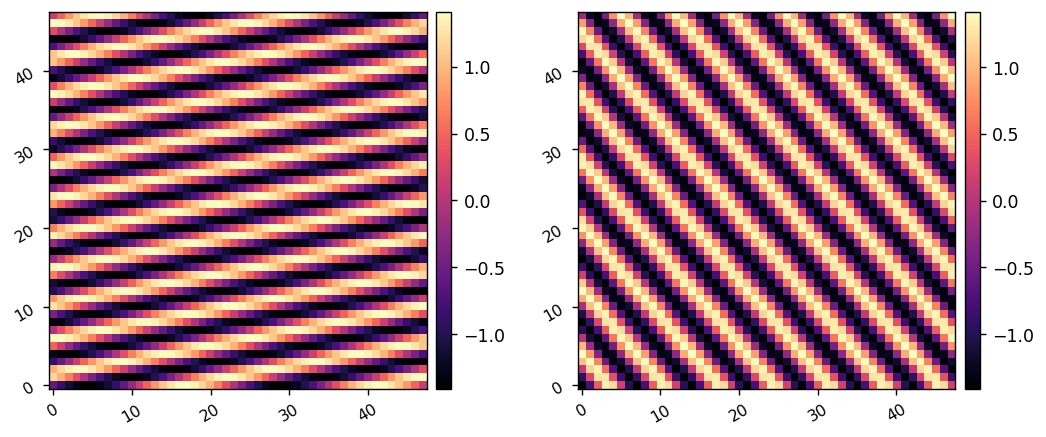

In [4]:
reload(iefc_sim)

Nact = hlci.Nact

fourier_modes, fx, fy = iefc_sim.create_fourier_modes(xfp, control_mask.reshape((npsf,npsf)), Nact, circular_mask=False)
probe_modes = iefc_sim.create_probe_poke_modes(hlci.Nact, 3*Nact//4, Nact//2, 3*Nact//4-1, Nact//2)

probe_amplitude = 0.05 * wavelength.to(u.m).value
calibration_amplitude = 0.006 * wavelength.to(u.m).value

print(fourier_modes.shape, probe_modes.shape)
misc.myimshow((probe_modes[0] - probe_modes[1]).reshape((Nact,Nact)))
misc.myimshow2(fourier_modes[0].reshape((Nact,Nact)), fourier_modes[300].reshape((Nact,Nact)))# Create probe and fourier modes

# Load response and calibration data

In [5]:
response_cube = fits.getdata(data_dir/'response-data'/'hlc_response_cube_ann_mask_2.fits')
calibration_cube = fits.getdata(data_dir/'calibration-data'/'hlc_calibration_cube_ann_mask_2.fits')
print(response_cube.shape, calibration_cube.shape)

(326, 2, 4096) (652, 4, 4096)


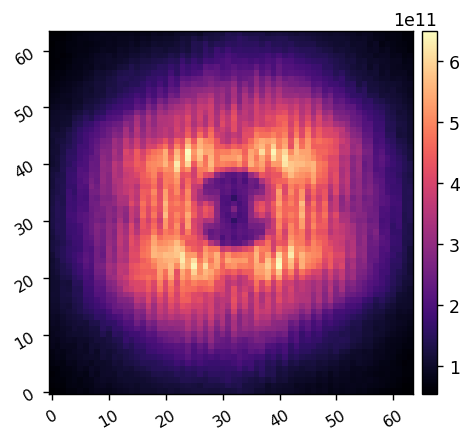

In [6]:
im = np.sum(abs(response_cube), axis=(0,1))
misc.myimshow(im.reshape(64,64))

# Filter calibration data (optional but unnecessary for static systems/simulations.

In [11]:
# Filter the calibration files by subtracting PCA modes
npca = 3
filtered_response_cube, pca_modes = iefc.remove_k_pca_modes(response_cube, k=npca)

# Create control matrix

In [8]:
# control_matrix = iefc.construct_control_matrix(response_cube, 
#                                                weights.flatten(), rcond=5e-2, pca_modes=None)
control_matrix = iefc_sim.construct_control_matrix(response_cube, 
                                                   weights.flatten(), rcond=5e-2, pca_modes=None)


# Run IEFC

Closed-loop iteration 1 / 10
(2304,) (326,)


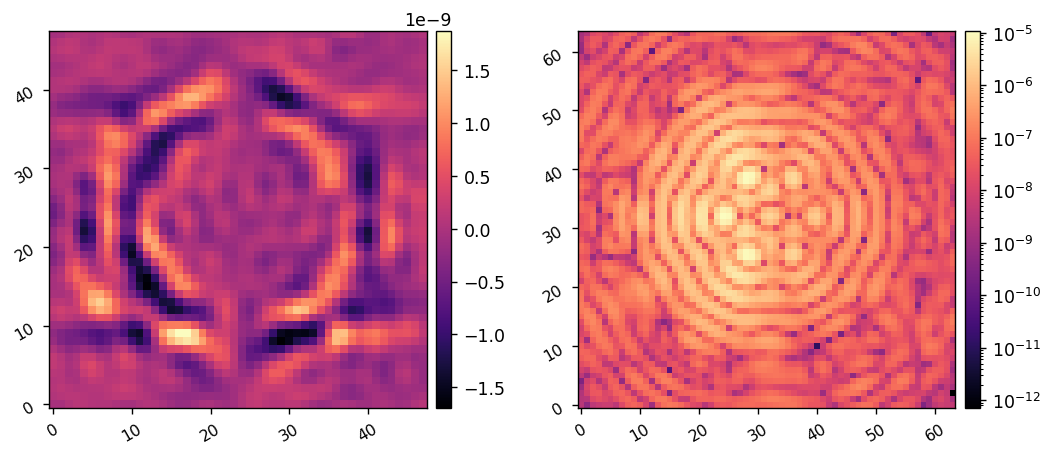

Closed-loop iteration 2 / 10
(2304,) (326,)


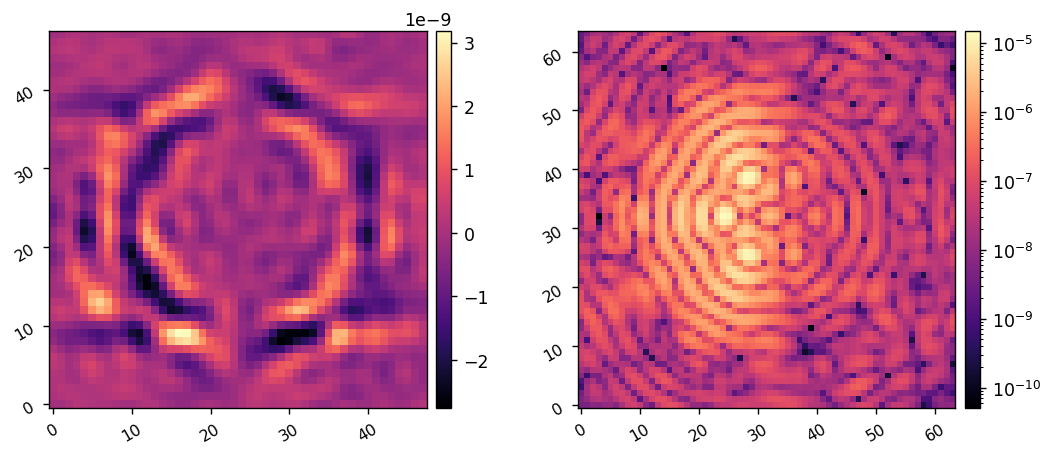

Closed-loop iteration 3 / 10
(2304,) (326,)


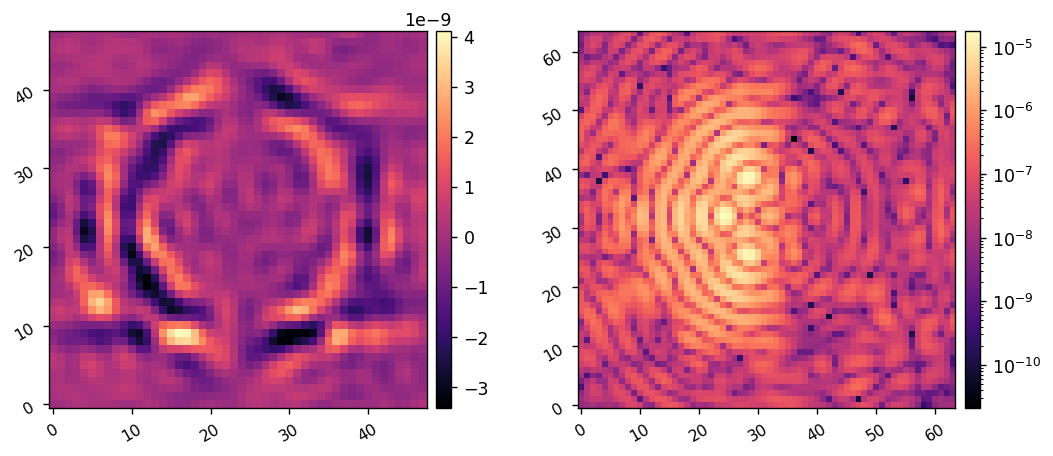

Closed-loop iteration 4 / 10
(2304,) (326,)


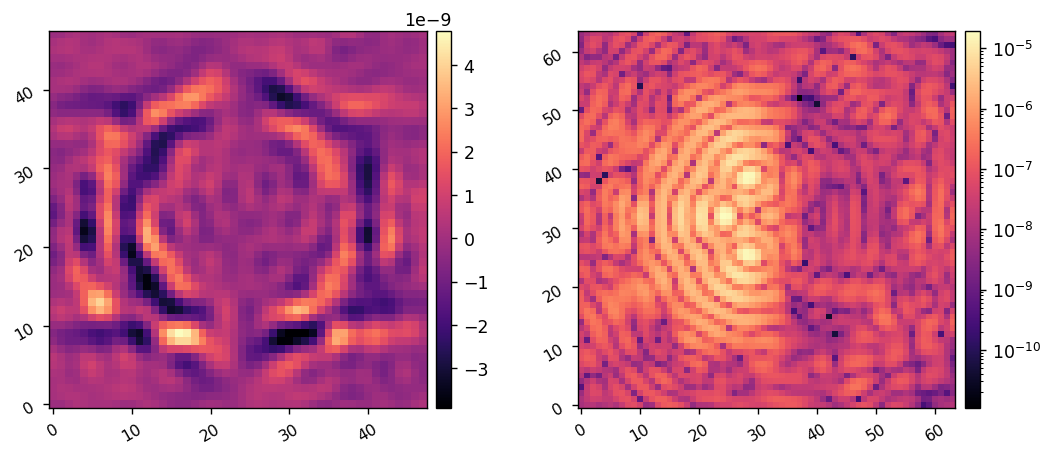

Closed-loop iteration 5 / 10
(2304,) (326,)


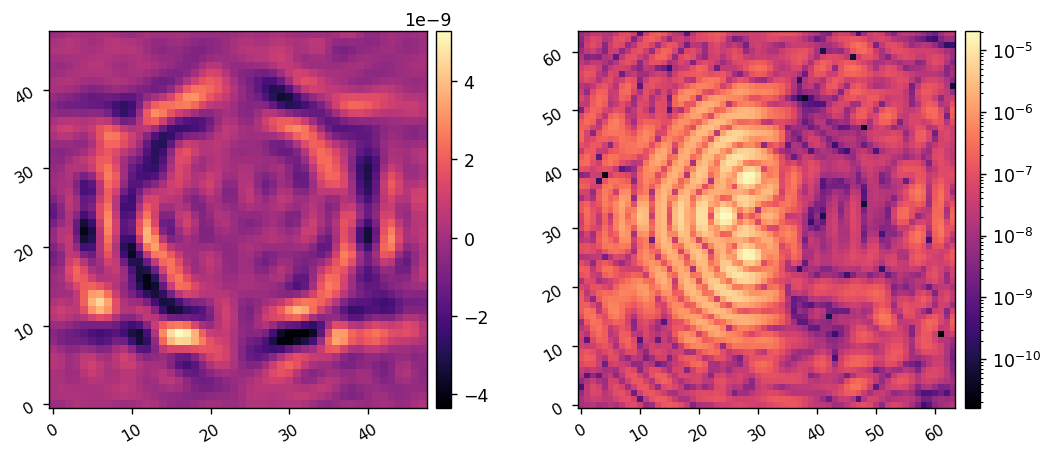

Closed-loop iteration 6 / 10
(2304,) (326,)


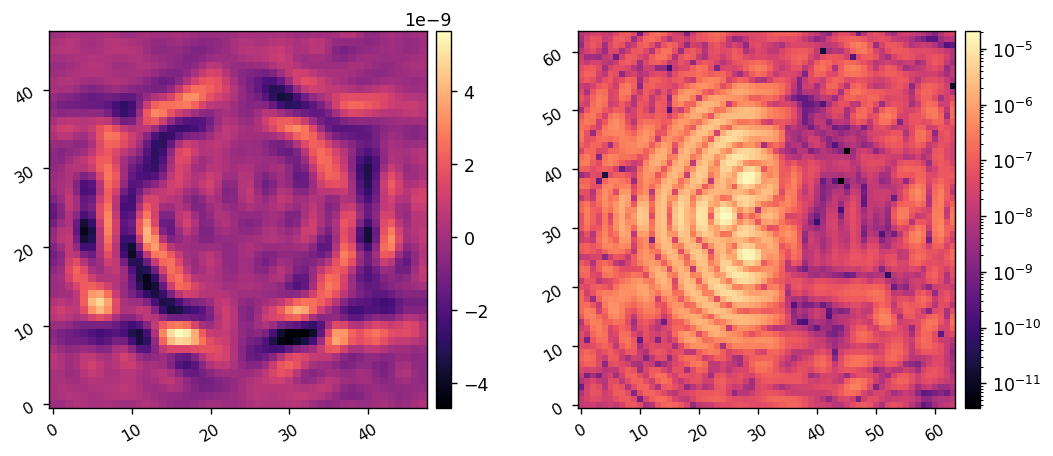

Closed-loop iteration 7 / 10
(2304,) (326,)


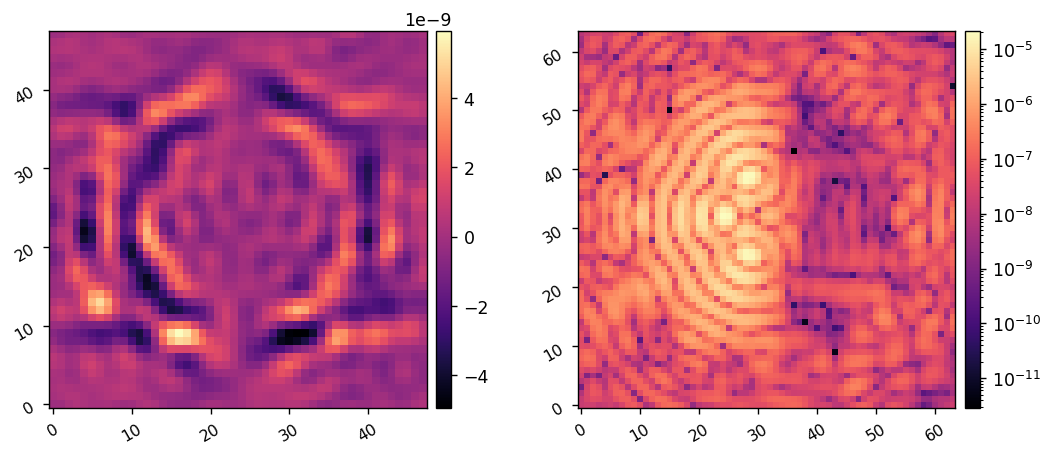

Closed-loop iteration 8 / 10
(2304,) (326,)


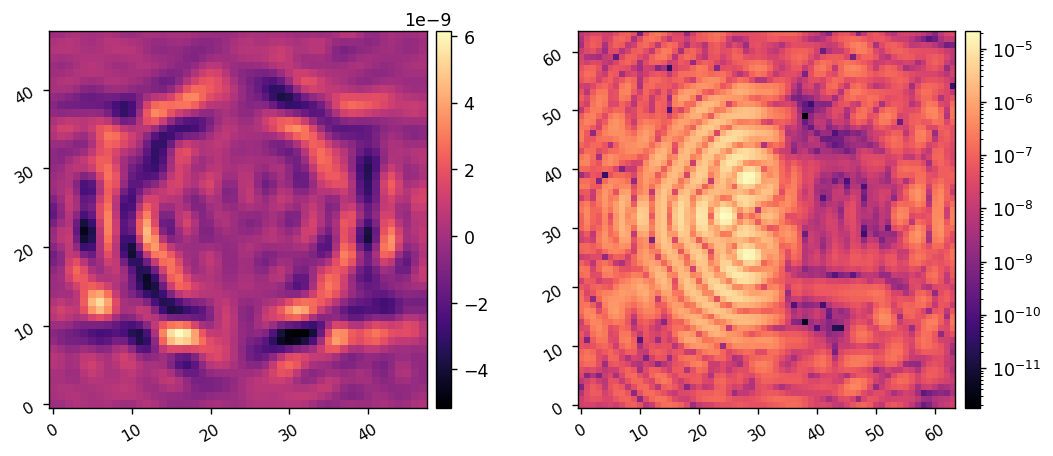

Closed-loop iteration 9 / 10
(2304,) (326,)


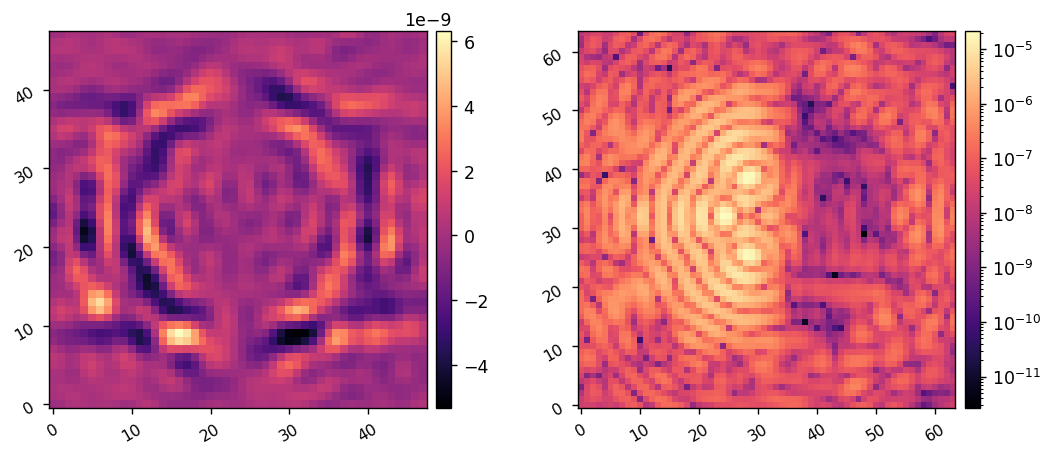

Closed-loop iteration 10 / 10
(2304,) (326,)


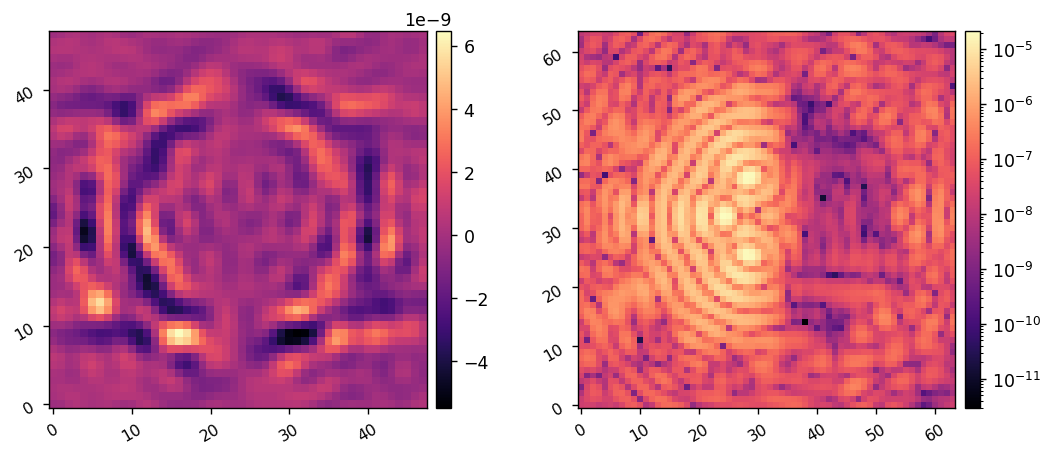

In [10]:
# The metric
metric_images = []
dm_commands = []
command = 0.0

## Run IEFC for num_iterations
num_iterations = 10
gain = -0.4
leakage = 0.0

for i in range(num_iterations):
    print("Closed-loop iteration {:d} / {:d}".format(i+1, num_iterations))
#     delta_coefficients = iefc_functions.IEFC_single_iteration(tbi, probe_modes, probe_amplitude, 
#                                                               control_matrix, weights>0)
    delta_coefficients = iefc_sim.single_iteration(hlci, probe_modes, probe_amplitude, 
                                                   control_matrix, weights.flatten()>0)
    command = (1.0-leakage) * command + gain * delta_coefficients
    
    # Reconstruct the full phase from the Fourier modes
    dm_command = np.einsum('ij, i->j', fourier_modes, command)
    print(dm_command.shape, delta_coefficients.shape)
    
    # Set the current DM state
#     tbi.set_dm(dm_command)
#     ret = tbi.send_dm()
    hlci.set_dm1(dm_command)
    
    # Take an image to estimate the metrics
#     metric_images.append(tbi.snap())
    image = hlci.calc_psf()
    metric_images.append(image)
    dm_commands.append(dm_command)
    
    misc.myimshow2(dm_command.reshape(Nact,Nact), image, lognorm2=True)
    pass

In [12]:
hdr = fits.Header()
hdr['GAIN'] = gain
hdr['LEAKAGE'] = leakage

images_hdu = fits.PrimaryHDU(data=metric_images, header=hdr)
images_hdu.writeto(data_dir/'image-results'/'ann_dh_2.fits', overwrite=True)
dms_hdu = fits.PrimaryHDU(data=dm_commands, header=hdr)
dms_hdu.writeto(data_dir/'dm-results'/'ann_dh_2.fits', overwrite=True)

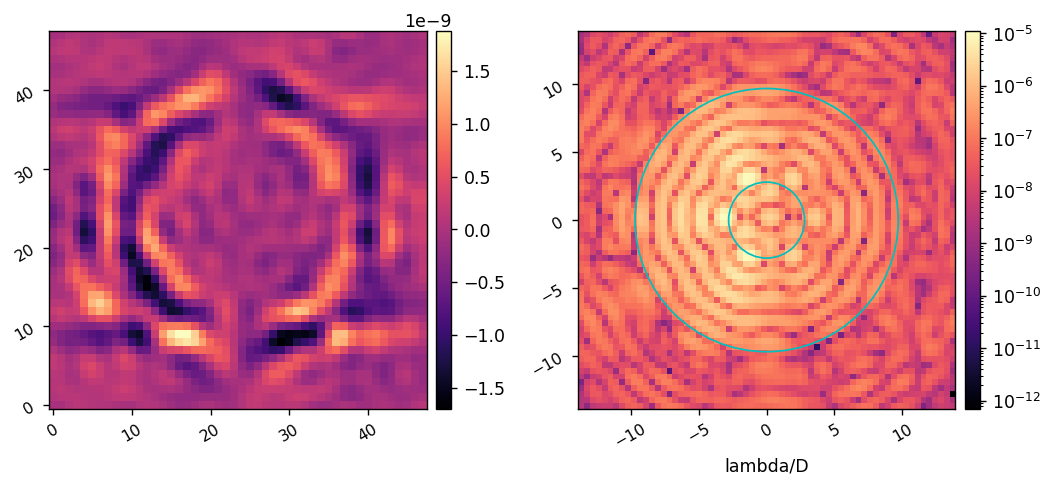

In [18]:
reload(iefc_sim)

ind = 0

patches = iefc_sim.create_circ_patches(dh_params)
misc.myimshow2(dm_commands[ind].reshape(Nact,Nact), metric_images[ind], 
               lognorm2=True, patches2=patches, pxscl2=psf_pixelscale_lamD.value)

# Testing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LogNorm
from matplotlib.animation import FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['animation.ffmpeg_path'] ='/.../bin/ffmpeg.exe'
plt.rcParams['animation.convert_path'] = '/.../magick.exe'
plt.rcParams['animation.html'] = 'html5'

wfs_min, wfs_max = (1, 0)
for i in range(len(images)):
    m, M = ( np.min(images), np.max(images) )
    if m < wfs_min: wfs_min = m
    if M > wfs_max: wfs_max = M

fig,ax = plt.subplots(1,2, figsize=(10,4), dpi=100)

dm_ext = np.array([-Nact/2, Nact/2, -Nact/2, Nact/2])*hlci.act_spacing.value
psf_ext = np.array([-npsf/2, npsf/2, -npsf/2, npsf/2])*psf_pixelscale_lamD
    
ax0 = ax[0].imshow(actuators[0], cmap='magma', extent=dm_ext)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar0 = fig.colorbar(ax0, cax=cax)
ax0_title = ax[0].set_title('Iteration {:d}'.format(range(15)[0]), fontsize = 18)

ax1 = ax[1].imshow(images[0], norm=LogNorm(), cmap='gist_heat', extent=psf_ext)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar0 = fig.colorbar(ax1, cax=cax)
ax1_title = ax[1].set_title('PSF', fontsize = 18)
ax1.add_patch(iefc.create_rect_patch(dh_params))

plt.close()

def animate(i):
    ax0.set_data(actuators[i])
    ax0.set_clim(np.min(actuators[i]), np.max(actuators[i]))
    ax0_title.set_text('Iteration {:d}'.format(range(15)[i]))
    
    ax1.set_data(wavefronts[i][-1].intensity)
    ax1.set_clim(wfs_min, wfs_max)
    ax1.add_patch(iefc.create_rect_patch(dh_params))

anim = animation.FuncAnimation(fig, animate, frames=len(actuators))
anim